# The clustering process
## Goal of this code

This code is to define a good method of clustering for a serie of pictures representing braided rivers behaviour. All we need is a time serie of pictures taken periodically (we took between 300 and 400 pictures), resized for faster computation ((150,100) pixels in our case) and converted in black and white (black is the water, white is the sand). Be careful, the pictures must be in one folder, in .png and must be numbered with the right number of digits like `image_001.png` so that the image n°11 does not go before the image n°2.

The outputs of the full program are :
- the pictures representing the most the clusters. They are called centroids.
- the matrix of euclidean distance between every pair of those centroids.
- the pi distribution, which is basically the number of points in one cluster over the number of clustered points, for every cluster.

## How does this code work ?

The process is decomposed this way :
1. Compute the MHD matrix between all the pairs of pictures of the experiment. The modified Hausdorff distance (MHD) is a measure of dissimilarity between pictures and will be our measure for the clustering. The cell `(i,j)` of the matrix corresponds to the MHD between image n°i and image n°j.
2. Compute the silhouette index for every combinaison of parameters of the clustering. Here, we use DBSCAN as our clustering algorithm because it has shown better results than k-medoids. This algorithm has two main parameters : `epsilon` and `min_samples` that can be changed to have a different clustering. To get the right parameters for nice separated and densed clusters, we use this [silhouette index](https://doi.org/10.1016/0377-0427(87)90125-7) as our measure of quality of the clustering. The result is a number between -1 and 1 and the closer it is to 1, the better the clustering is.
3. Do the clustering with the right parameters using DBSCAN.
4. Visualize the results with different dimension reduction spaces. Those plots allow us to see if the clustering is relevant, to define the centroids and to compute the distance matrix between the centroids. We use three different visualization techniques that were used in different papers.
5. Choose the best results and save those in the computer into .npy files.
6. Validate the choice of the centroids with the area visited by flow. It is a measure of how representative of the time serie the centroids are.

## The parameters
### For the MHD matrix

- `folderExp` is the path of the folder where the pictures of the experiment are saved.
- `prefix` is the path of the folder where the MHD matrix .npy file will be saved.

### For the silhouette index

- `mhd_matrix` is the path of the .npy file representing the MHD matrix that was computed before.
- `min_samples_list` and `epsilon_list` are the values of the DBCSAN parameters that we want to try to find the maximum value of the silhouette index. The values of `min_samples` must be unsigned int that represent the minimum number of points in a cluster. The values of `epsilon` are unsigned float.
- `min_points` is the minimum of points considered as clustered points that we want. In fact, the DBSCAN algorithm separates the points into noise and clustered points. As we do not want all the points to be noise, we have to fix this condition to get representative parameters for the clustering.

### For the clustering

- `min_samples` and `epsilon` are the parameters of the DBSCAN that have a high silhouette index.

### For the UMAP

- `n_neighbors` and `min_dist` are the parameters of the UMAP. We can change those for better visualization.

### For the t-SNE

- `random_state`, `n_iter`, `perplexity` and `early_exaggeration` are the parameters of the t-SNE. We can change those for better visualization.

### For the saving of the outputs

- `folder_centroids` is the path of the folder where the chosen centroids will be saved.
- `folder_npy` is the path of the folder where the distance matrix and the pi distribution will be saved as .npy files.

## The functions

All the functions used in this code are in the package functionsClustering.py. Here is a small description of each :
- `GetCentroids` reads all the pictures of the folder in input and save them into a list. It is for faster use of the images after. In fact, we just have to 'imread' the images once in for all.
- `MHDMatrixJulia` computes the MHD matrix between all the pictures saved in the folder in input. It converts all the images into edges with a Julia function and calculates the MHD pairwise by calling de J. Hoffimann's Julia package in Python.
- `DBSCAN_sihouette` computes the silhouette score for every combinaison parameters we want to try. In our case, as we have two parameters, the output of the function is a matrix where the rows are parametized by `min_samples` and the columns by `epsilon`.
- `DBSCAN_clustering` does the DBSCAN clustering of the MHD matrix with the wanted parameters. The output is a list of the cluster labels, which attributes to every images a number corresponding to one cluster. Some pictures have a number -1 which means that they are considered to be noise.
- `DBSCAN_distance_matrix` computes the euclidean distance matrix between all the pairs of centroids in the chosen visualization space.
- `DBSCAN_centroids` defines the points considered to be centroids. It computes the coordinates of the center of the cluster in the visualization space and takes the closest point to be the centroid.
- `DBSCAN_pi` gives the pi distribution of the clustering.
- `cumulative_sum_with_limit` computes the cumulative sum of the images, with each pixel value limited to 1. It is used in the area visited by flow at the end of the notebook.

# Importing the librairies

In [14]:
# Librairies
from umap import UMAP
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from matplotlib.patches import Polygon
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import time
from PIL import Image
import os
import shutil
import re
import matplotlib.colors as mcolors

import functionsClustering as f

# Computing the MHD matrix

In [2]:
# Put the path of the folder where the pictures of the experiment are saved
folderExp = 'C:/Users/EPFL-LHE/Documents/Arthur/Experiment-Hoffiman-BW/BW-oneDay'

In [3]:
# Compute the MHD matrix between all the pictures of the experiment
startTime = time.time()
D = f.MHDMatrixJulia(folderExp)
endTime = time.time()
duration = endTime - startTime
print(f"The code took {duration} secondes to run.")

Ligne 0 sur 300
Ligne 1 sur 300
Ligne 2 sur 300
Ligne 3 sur 300
Ligne 4 sur 300
Ligne 5 sur 300
Ligne 6 sur 300
Ligne 7 sur 300
Ligne 8 sur 300
Ligne 9 sur 300
Ligne 10 sur 300
Ligne 11 sur 300
Ligne 12 sur 300
Ligne 13 sur 300


KeyboardInterrupt: 

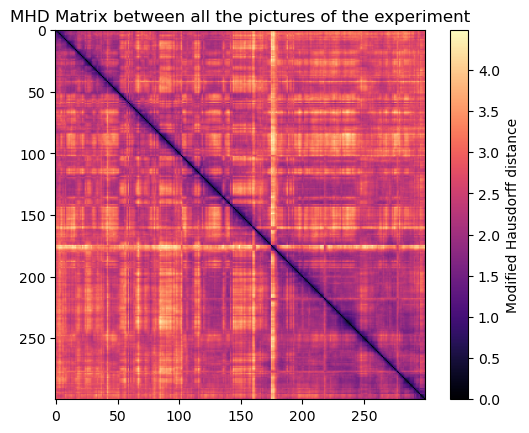

In [4]:
# Plot the matrix
plt.magma()
plt.imshow(D)
plt.title('MHD Matrix between all the pictures of the experiment')
plt.colorbar(format='%.1f', label='Modified Hausdorff distance')
plt.show()

In [5]:
# Save the matrix as an npy
prefix = 'C/Users/.../NPYFiles'
np.save(prefix + '/MHDMatrix.npy', D)

FileNotFoundError: [Errno 2] No such file or directory: 'C/Users/.../NPYFiles/MHDMatrix.npy'

# Clustering with DBSCAN

## The silhouette index 

The DBSCAN algorithm is really tricky and the results of the clustering can be very weird depending on the parameters (min_samples and epsilon) that we choose.
Therefore, we use the [silhouette index](https://doi.org/10.1016/0377-0427(87)90125-7) as a measure of the quality of a clustering. The result is a number between -1 and 1 and the closer it is to 1, the better the clustering is. 
As the DBSCAN algorithm does not have a parameter that plays with the number of clusters like k-means, we have to variate the two parameters in a double for loop to make the clustering different.

Top 3 silhouette score: 0.36976518713032636
min_samples: 4, epsilon: 3.41025641025641
Top 2 silhouette score: 0.3739825483342423
min_samples: 5, epsilon: 3.717948717948718
Top 1 silhouette score: 0.38302097409202207
min_samples: 6, epsilon: 3.923076923076923


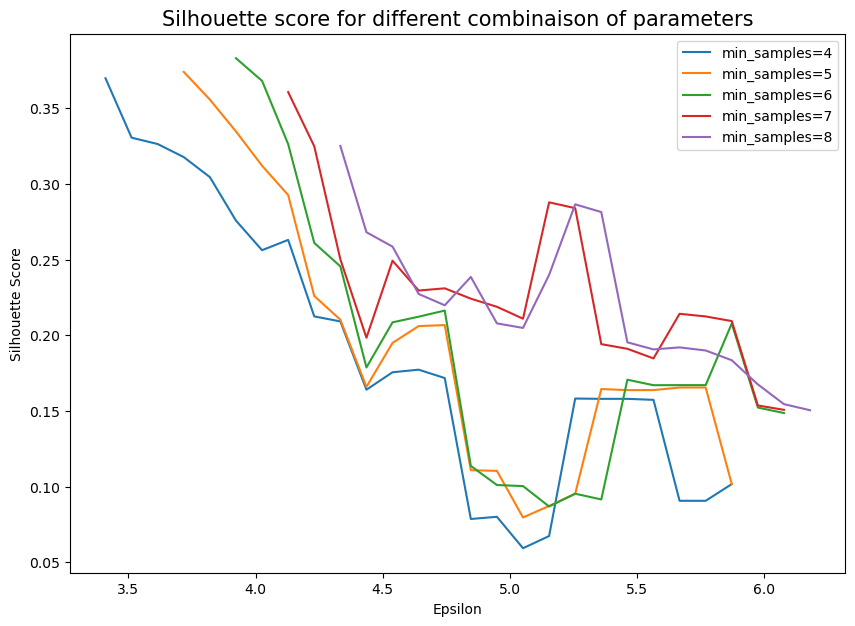

In [4]:
# Load the MHD matrix from a npy file
mhd_matrix = np.load('C:/Users/EPFL-LHE/Documents/Arthur/MHDMatrix/MHD_oneDay2.npy')

# Parameters to try for the DBSCAN clustering
min_samples_list = [4,5,6,7,8]
epsilon_list = np.linspace(3,7,40)

# Minimum points required for the silhouette index to be computed. If there is too much noise, it is no longuer relevant
min_points = 150

# Get the silhouette index for each combinaison of parameters
list_silhouette = f.DBSCAN_sihouette(mhd_matrix, min_samples_list, epsilon_list, min_points)

# Find the indices of the highest silhouette score
top3_indices_1d = np.argpartition(list_silhouette.flatten(), -3)[-3:]
top3_indices_2d = np.unravel_index(top3_indices_1d, list_silhouette.shape)

# Get the corresponding values of min_samples and epsilon
top3_min_samples = np.array(min_samples_list)[top3_indices_2d[0]]
top3_epsilon = np.array(epsilon_list)[top3_indices_2d[1]]

# Print the 3 best values of epsilon and min_samples
for i in range(3):
    print(f"Top {3-i} silhouette score: {list_silhouette[top3_indices_2d[0][i], top3_indices_2d[1][i]]}")
    print(f"min_samples: {top3_min_samples[i]}, epsilon: {top3_epsilon[i]}")

# Plot the silhouette index for different combinaison of parameters
fig, ax = plt.subplots(figsize=(10, 7))
for i, min_samples in enumerate(min_samples_list):
    ax.plot(epsilon_list, list_silhouette[i], label=f'min_samples={min_samples}')

# Plot parameters
ax.set_xlabel('Epsilon')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette score for different combinaison of parameters', fontsize=15)
ax.legend(loc='best')
plt.show()

## The clustering

Now that we have the parameters that ensure the quality of our clustering, we can just do the clustering with those.

In [5]:
# DBSCAN parameters (chose based on the silhouette index)
min_samples = 6
epsilon = 3.923

# Doing the clustering
cluster_labels, cluster_labels_filtered, unique_labels, noise_mask = f.DBSCAN_clustering(mhd_matrix, min_samples, epsilon)

# Print some infos about the clustering
print(f'Number of clusters : {len(unique_labels)}')
print(f'Number of points : {len(cluster_labels_filtered)} on {len(cluster_labels)}')

Number of clusters : 13
Number of points : 151 on 300


# The visualization of the clusters

In this part, we want to visualize our data to validate or not the choice of the clusters. 

We will try three different dimensions reduction techniques to visualize in 2D our clustering : UMAP, t-SNE and MDS, that were used in previous papers. It is relevant to say that those techniques are stochastic which changes the visualization every time we run the programm. For every visualization, there are parameters defined at the beginning of the cell that plays with the distribution of points. We can obviously change those parameters so that the visualization matches the most with our data.

We colored in black the points considered as noise and in color the clustered points. The color represents the position of the image in the time serie. We also define some points as centroids, which are considered to be pictures that represent the most their cluster. We first define the center of the cluster in the visualization space and the centroid is the point closer to this center. Those special points are represented with crosses in the first plot. We can see that the centroids are different every time we run the code because the visualization changes. It is then important to validate the choice of those centroids, which is a part that is done afterwards in this notebook.

In addition to the visualization, we define a matrix that is based on the euclidean distance between the coordinates of each centroids in the chosen space. This matrix is a good way of seeing the dissimilarity between the modes. Plus, we need it anyway in the Markov process afterwards.

## UMAP

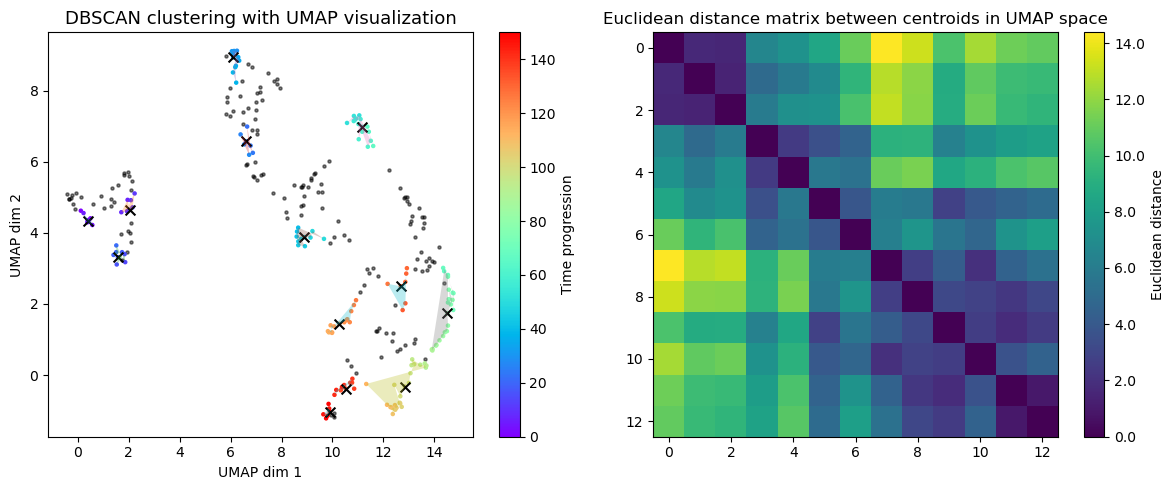

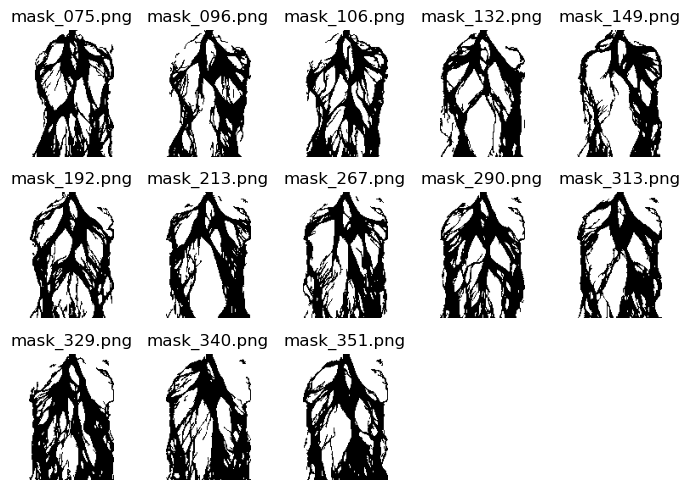

In [17]:
# UMAP parameters
n_neighbors = 15
min_dist = 0.25

# Apply UMAP on the data for dimensionality reduction
model = UMAP(n_neighbors = n_neighbors, min_dist = min_dist, n_components = 2)
X_umap = model.fit_transform(mhd_matrix)
X_umap_filtered = X_umap[noise_mask]

# Get the euclidean distance matrix between the centroids from the UMAP space
distance_matrix = f.DBSCAN_distance_matrix(X_umap_filtered, unique_labels, cluster_labels_filtered)

# Get the indices of the centroids
centroids_indices = f.DBSCAN_centroids(X_umap_filtered, unique_labels, cluster_labels, cluster_labels_filtered)

# Create a colormap for the polygons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))  # Two subplots side by side
cmap = plt.get_cmap('tab10')

# Scatter plot with colors representing time progression and black for the noise
sc = ax1.scatter(X_umap[~noise_mask,0], X_umap[~noise_mask,1], marker='.', s=20, c='black', alpha = 0.5)
sc = ax1.scatter(X_umap[noise_mask,0], X_umap[noise_mask,1], marker='.', s=20, c=np.arange(len(X_umap[noise_mask])), cmap='rainbow')

# Plot centroids with crosses
medoids_points = X_umap[centroids_indices]
ax1.scatter(medoids_points[:, 0], medoids_points[:, 1], marker='x', s=50, c='black')

# Iterate over each unique label and plot polygons
for label_idx, label in enumerate(unique_labels):
    # Select the points that belong to the current cluster
    cluster_points = X_umap_filtered[cluster_labels_filtered == label]
    
    # If we have more than 2 points (needed for polygon), we add the polygon
    if len(cluster_points) > 2:
        poly = Polygon(cluster_points, facecolor=cmap(label_idx), alpha=0.3)
        ax1.add_patch(poly)
        
# Esthetic  
ax1.set_xlabel('UMAP dim 1')
ax1.set_ylabel('UMAP dim 2')
ax1.set_title('DBSCAN clustering with UMAP visualization', fontsize=13)
fig.colorbar(sc, ax=ax1, label='Time progression')

# Plot the distance matrix
im = ax2.imshow(distance_matrix)
ax2.set_title('Euclidean distance matrix between centroids in UMAP space')
fig.colorbar(im, ax=ax2, format='%.1f', label='Euclidean distance')

# Show the figure
plt.tight_layout()
plt.show()

# Plot the centroids
grid_size = (3, 5)
plt.figure(figsize=(7, 5))

# Get the pictures 
allFiles = os.listdir(folderExp)
files = [file for file in allFiles]

# Loop over the centroids_indices and show the corresponding images
for i, centroid_index in enumerate(centroids_indices, start=1):
    # Define the image path
    image_path = os.path.join(folderExp, files[centroid_index])
    
    # Open the image and convert it to grayscale
    img = Image.open(image_path).convert('L')
    
    # Add the image to the figure
    plt.subplot(grid_size[0], grid_size[1], i)
    plt.imshow(img, cmap='gray')  # Add a grayscale colormap
    plt.title(files[centroid_index])
    plt.axis('off')  # To hide axis values

# Show the figure
plt.tight_layout()
plt.show()


UMAP is known to capture well distances between clusters as well as within one cluster. The result seems very fine as the plot shows densed clusters that are far apart from each others. Plus, the centroids look different and well distributed in time.

## t-SNE

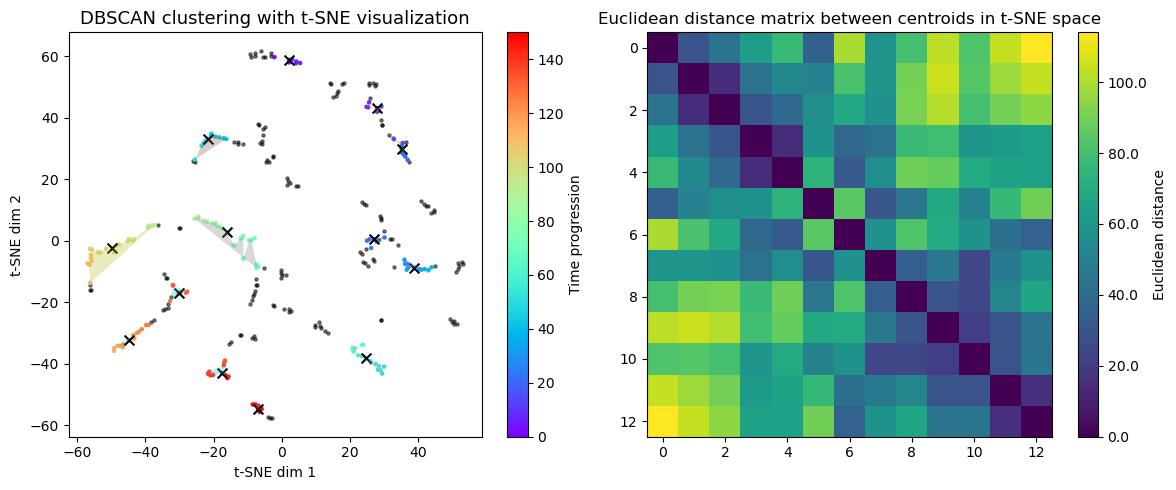

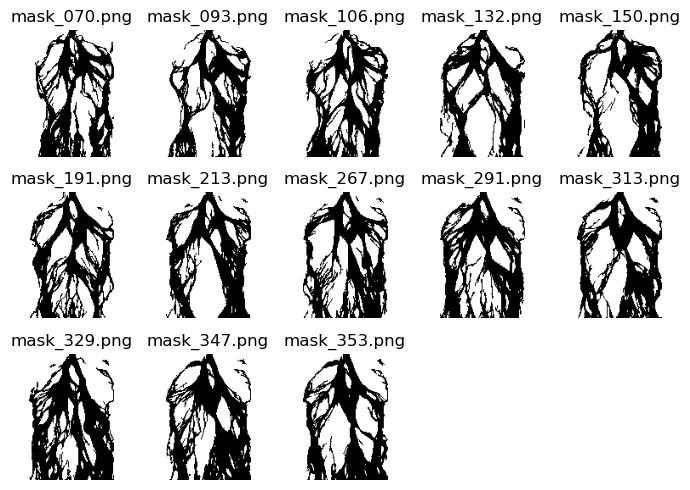

In [20]:
# t-SNE parameters 
random_state = 10
n_iter = 1000
perplexity = 5
early_exaggeration = 6

# Apply t-SNE on the data for dimensionality reduction
tsne = TSNE(n_components=2, random_state=random_state, n_iter = n_iter, perplexity = perplexity, early_exaggeration=early_exaggeration)
X_tsne = tsne.fit_transform(mhd_matrix)
X_tsne_filtered = X_tsne[noise_mask]

# Get the euclidean distance matrix between the centroids from the t-SNE space
distance_matrix = f.DBSCAN_distance_matrix(X_tsne_filtered, unique_labels, cluster_labels_filtered)

# Get the indices of the centroids
centroids_indices = f.DBSCAN_centroids(X_tsne_filtered, unique_labels, cluster_labels, cluster_labels_filtered)

# Create a colormap for the polygons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))  # Two subplots side by side
cmap = plt.get_cmap('tab10')

# Scatter plot with colors representing time progression
sc = ax1.scatter(X_tsne[~noise_mask,0], X_tsne[~noise_mask,1], marker='.', s=20, c='black', alpha = 0.5)
sc = ax1.scatter(X_tsne[noise_mask,0], X_tsne[noise_mask,1], marker='.', s=20, c=np.arange(len(X_tsne[noise_mask])), cmap='rainbow')

# Plot centroids with crosses
medoids_points = X_tsne[centroids_indices]
ax1.scatter(medoids_points[:, 0], medoids_points[:, 1], marker='x', s=50, c='black')

# Iterate over each unique label and plot polygons
for label_idx, label in enumerate(unique_labels):
    # Select the points that belong to the current cluster
    cluster_points = X_tsne_filtered[cluster_labels_filtered == label]
    
    # If we have more than 2 points (needed for polygon), we add the polygon
    if len(cluster_points) > 2:
        poly = Polygon(cluster_points, facecolor=cmap(label_idx), alpha=0.3)
        ax1.add_patch(poly)

# Esthetic   
ax1.set_xlabel('t-SNE dim 1')
ax1.set_ylabel('t-SNE dim 2')
ax1.set_title('DBSCAN clustering with t-SNE visualization', fontsize=13)
fig.colorbar(sc, label='Time progression')

# Plot the distance matrix
im = ax2.imshow(distance_matrix)
ax2.set_title('Euclidean distance matrix between centroids in t-SNE space')
fig.colorbar(im, ax=ax2, format='%.1f', label='Euclidean distance')

# Show the figure
plt.tight_layout()
plt.show()

# Plot the centroids
grid_size = (3, 5)
plt.figure(figsize=(7, 5))

# Get the pictures 
allFiles = os.listdir(folderExp)
files = [file for file in allFiles]

# Loop over the centroids_indices and show the corresponding images
for i, centroid_index in enumerate(centroids_indices, start=1):
    # Define the image path
    image_path = os.path.join(folderExp, files[centroid_index])
    
    # Open the image and convert it to grayscale
    img = Image.open(image_path).convert('L')
    
    # Add the image to the figure
    plt.subplot(grid_size[0], grid_size[1], i)
    plt.imshow(img, cmap='gray')
    plt.title(files[centroid_index])
    plt.axis('off')  # To hide axis values

# Show the figure
plt.tight_layout()
plt.show()


The t-SNE visualization shows lines of points instead of groups as in the UMAP. Still, the clusters are well separated and the points that are close to each others belong to one cluster.
But this algorithm of visualization is known for not computing well distances between clusters, so the distance matrix is no longuer relevant in this case.

We also note that t-SNE projects the points in a way bigger projection than UMAP. Therefore, the distances of the matrix are 10 times higher than before, which will have an importance afterwards if we choose this distance matrix.
This type of visualization is used in the 2019 [paper](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2019JF005245) of J.Hoffimann .

## MDS

C:\Users\EPFL-LHE\mambaforge\envs\Arthur\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
C:\Users\EPFL-LHE\mambaforge\envs\Arthur\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


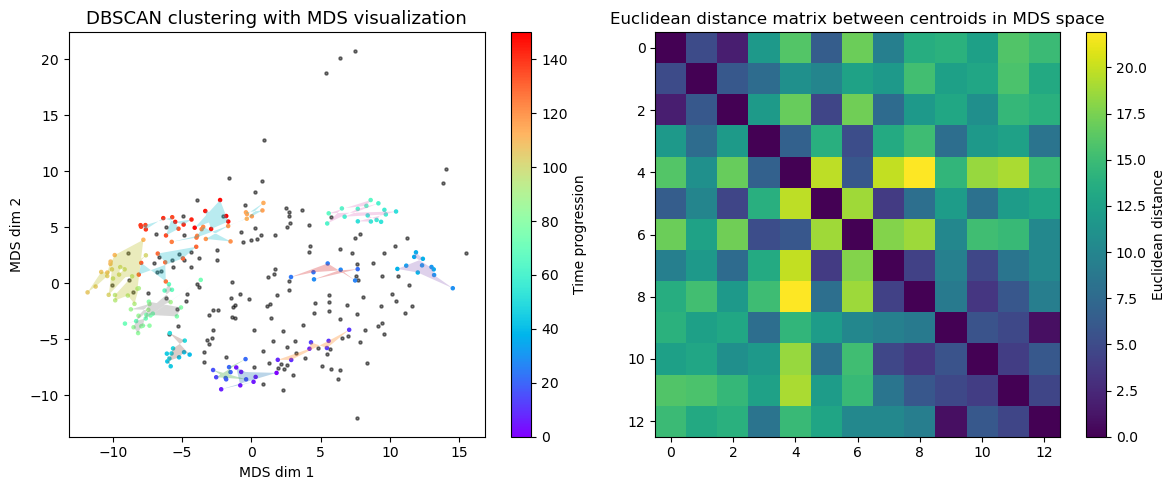

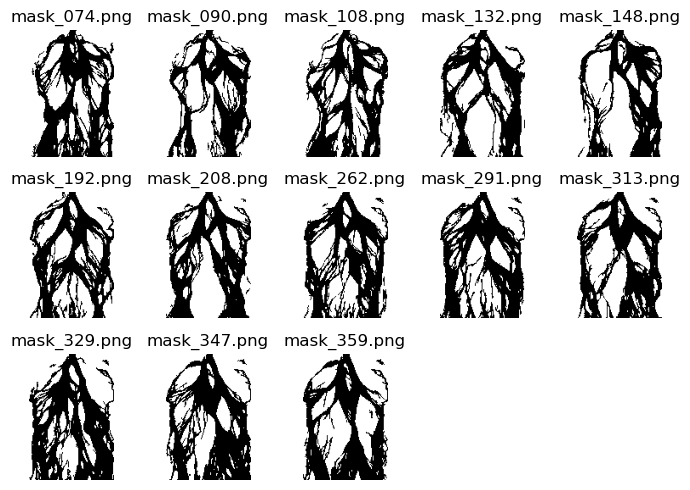

In [21]:
# MDS parameter
n_components = 2

# Apply MDS on the data for dimensionality reduction
model = MDS(n_components = n_components)
X_mds = model.fit_transform(mhd_matrix)
X_mds_filtered = X_mds[noise_mask]

# Get the euclidean distance matrix between the centroids from the t-SNE space
distance_matrix = f.DBSCAN_distance_matrix(X_mds_filtered, unique_labels, cluster_labels_filtered)

# Get the indices of the centroids
centroids_indices = f.DBSCAN_centroids(X_mds_filtered, unique_labels, cluster_labels, cluster_labels_filtered)

# Create a colormap for the polygons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))  # Two subplots side by side
cmap = plt.get_cmap('tab10')

# Scatter plot with colors representing time progression
sc = ax1.scatter(X_mds[~noise_mask,0], X_mds[~noise_mask,1], marker='.', s=20, c='black', alpha = 0.5)
sc = ax1.scatter(X_mds[noise_mask,0], X_mds[noise_mask,1], marker='.', s=20, c=np.arange(len(X_mds[noise_mask])), cmap='rainbow')

# Plot centroids with crosses
medoids_points = X_mds[centroids_indices]
ax.scatter(medoids_points[:, 0], medoids_points[:, 1], marker='x', s=50, c='black')

# Iterate over each unique label and plot polygons
for label_idx, label in enumerate(unique_labels):
    # Select the points that belong to the current cluster
    cluster_points = X_mds_filtered[cluster_labels_filtered == label]
    
    # If we have more than 2 points (needed for polygon), we add the polygon
    if len(cluster_points) > 2:
        poly = Polygon(cluster_points, facecolor=cmap(label_idx), alpha=0.3)
        ax1.add_patch(poly)
 
# Esthetic   
ax1.set_xlabel('MDS dim 1')
ax1.set_ylabel('MDS dim 2')
ax1.set_title('DBSCAN clustering with MDS visualization', fontsize=13)
fig.colorbar(sc, label='Time progression')

# Plot the distance matrix
im = ax2.imshow(distance_matrix)
ax2.set_title('Euclidean distance matrix between centroids in MDS space')
fig.colorbar(im, ax=ax2, format='%.1f', label='Euclidean distance')

# Show the figure
plt.tight_layout()
plt.show()

# Plot the centroids
grid_size = (3, 5)
plt.figure(figsize=(7, 5))

# Get the pictures 
allFiles = os.listdir(folderExp)
files = [file for file in allFiles]

# Loop over the centroids_indices and show the corresponding images
for i, centroid_index in enumerate(centroids_indices, start=1):
    # Define the image path
    image_path = os.path.join(folderExp, files[centroid_index])
    
    # Open the image and convert it to grayscale
    img = Image.open(image_path).convert('L')
    
    # Add the image to the figure
    plt.subplot(grid_size[0], grid_size[1], i)
    plt.imshow(img, cmap='gray')
    plt.title(files[centroid_index])
    plt.axis('off')  # To hide axis values

# Show the figure
plt.tight_layout()
plt.show()

"Multidimensional scaling (MDS) is a means of visualizing the level of similarity of individual cases of a dataset. MDS is used to translate "information about the pairwise 'distances' among a set of nn} objects or individuals" into a configuration one n} points mapped into antract Cartesian space" [source](https://en.wikipedia.org/wiki/Multidimensional_scaling).

We can clearly see that the clusters are not distinctly separated, as all the points are like grouped into one big cluster. But, the polygons that represent the clusters from DBSCAN are not superimposed which confirms the clustering. 
MDS is used in 2016 [paper](https://agupubs.onlinelibrary.wiley.com/share/YJ73DCH3YFC7PKHWXGXM?target=10.1002/2016JF003922) form C. Scheidt..[1]

# Get the selected centroids, the distance matrix and pi

Now that we established a method to get a nice clustering and a good visualization, we can save the relevant data into npy files so that we can use them afterwards.

## Copy paste the centroids in a new folder

In [ ]:
# Define the destination folder
folder_centroids = "/path/to/destination_folder"  # Change this to your destination folder

# Create the destination folder if it does not exist
os.makedirs(folder_centroids, exist_ok=True)

# Loop over the centroids_indices and copy the corresponding images
for i, centroid_index in enumerate(centroids_indices):
    # Define the source image path
    image_path = os.path.join(folderExp, files[centroid_index])
    
    # Define the destination image path
    destination_image_path = os.path.join(folder_centroids, files[centroid_index])
    
    # Copy the image to the destination folder
    shutil.copy(image_path, destination_image_path)

print(f"{len(centroids_indices)} centroid images copied to {folder_centroids}.")

## Save the distance matrix and pi into npy files

We can easily save the distance matrix defined earlier into a npy file. Pi is a list of proportion of points into clusters. It is define as the number of points in one cluster over the total number of clustered points, for every cluster. We also save this list as we will use it afterwards in the process.

In [ ]:
# Define the destination folder
folder_npy = "/path/to/destination_folder"  # Change this to your destination folder

# Create the destination folder if it does not exist
os.makedirs(folder_npy, exist_ok=True)

# Save the distance matrix into the folder 
np.save(folder_npy + 'distanceMatrix.npy', distance_matrix)

# Compute pi
pi = DBSCAN_pi(mhd_matrix, unique_labels, cluster_labels_filtered)

# Save pi into the same folder
np.save(folder_npy + 'pi.npy', pi)

# Area visited by the flow

Even though we validated the clustering, it is still relevant to check if the centroids represent well the time serie.
For that, we plot the area visited by flow, which is basically looking for blanck spots in the sum of every pictures. 

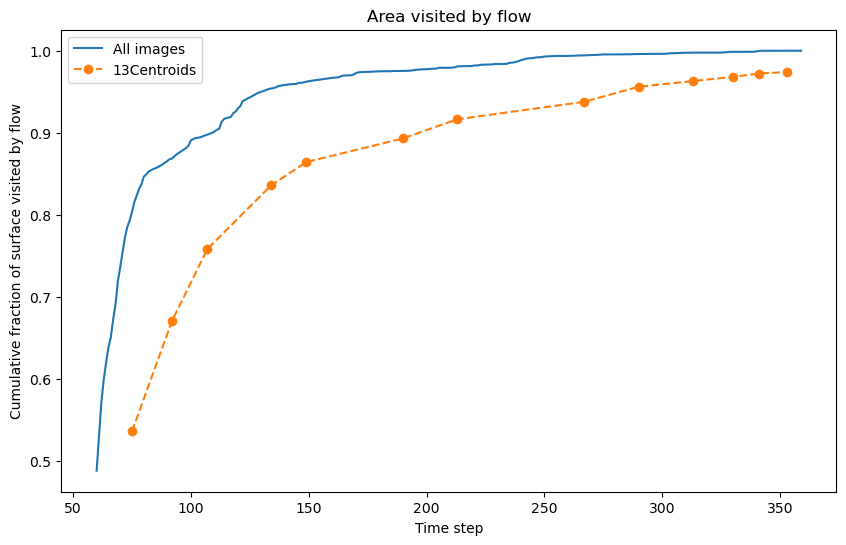

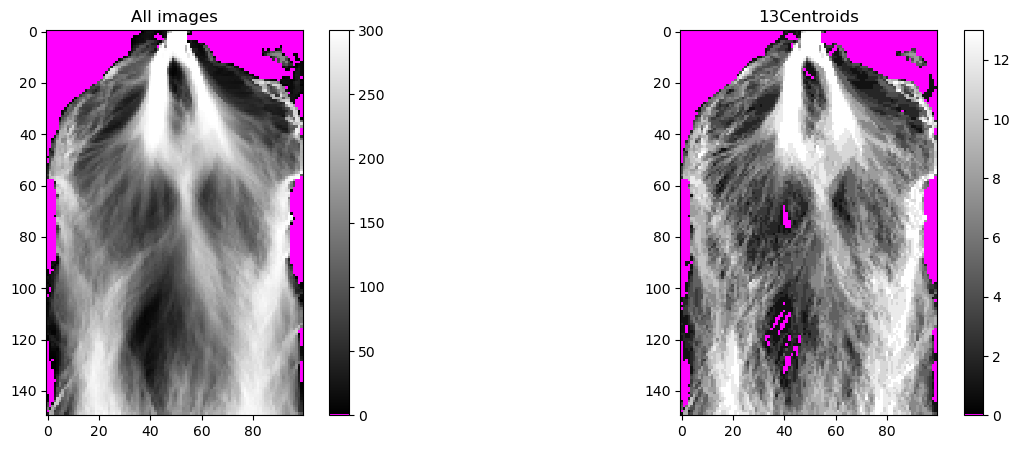

In [23]:
# Get the centroids in the folder
folder_centroids = 'C:/Users/EPFL-LHE/Documents/Arthur/Centroids/REALCentroidsDBSCAN/13Centroids'

# Select the experimental time serie
picturesExp = f.GetCentroids(folderExp)

# Tranform the list of pictures into one 3D array and reverse the pictures
dataset = np.zeros((len(picturesExp), picturesExp[0].shape[0], picturesExp[0].shape[1]))
for i in range(len(picturesExp)):
    dataset[i,:,:] = 1-picturesExp[i]

# Calculate the cumulative fraction of the surface visited by flow for the dataset 
dataset_cumulative_surface_visited = np.sum(f.cumulative_sum_with_limit(dataset), axis=(1,2))

# Calculate the total surface visited by flow in the dataset and the training images
dataset_total_surface_visited = np.sum(dataset, axis=0)

# Normalize the fraction of surface visited
final_surface = dataset_cumulative_surface_visited[-1]
dataset_cumulative_surface_visited = dataset_cumulative_surface_visited/final_surface

# Create the cumulative flow visitation plot
plt.figure(figsize=(10, 6))
plt.plot(range(60,360), dataset_cumulative_surface_visited, label='All images')

# Select the centroids from the folder
centroids = f.GetCentroids(folder_centroids)

# Tranform the list of pictures into one 3D array and reverse the pictures
dataset2 = np.zeros((len(centroids), centroids[0].shape[0], centroids[0].shape[1]))
for i in range(len(centroids)):
    dataset2[i,:,:] = 1-centroids[i]

# Calculate the cumulative fraction of the surface visited by flow for the centroids and normalize it
centroids_cumulative_surface_visited = np.sum(f.cumulative_sum_with_limit(dataset2), axis=(1,2))
centroids_cumulative_surface_visited = centroids_cumulative_surface_visited/final_surface

# Get all the centroids in the folder
allFiles = os.listdir(folder_centroids)
centroid_files = [file for file in allFiles if file.endswith(".png")]

# Extract the numbers from the filenames and convert to int
numbers = [int(re.search(r'\d+', file).group()) for file in centroid_files]

# Calculate the total surface visited by flow in the dataset and the training images
centroids_total_surface_visited = np.sum(dataset2, axis=0)

# Plot the cumulative fraction of surface visited by flow
plt.plot(numbers, centroids_cumulative_surface_visited, label=os.path.basename(folder_centroids), linestyle='--', marker='o')
plt.xlabel('Time step')
plt.ylabel('Cumulative fraction of surface visited by flow')
plt.title('Area visited by flow')
plt.legend()
plt.show()

# Create a custom colormap for 
colors = [(0, "magenta"), (0.00001, "black"), (1, "white")]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

# Create the flow occupation maps
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Save the reference to the imshow objects
im1 = axs[0].imshow(dataset_total_surface_visited, cmap=cmap, interpolation='nearest')
axs[0].set_title('All images')

# Create a colorbar for the first subplot
fig.colorbar(im1, ax=axs[0], orientation='vertical')

im2 = axs[1].imshow(centroids_total_surface_visited, cmap=cmap, interpolation='nearest')
axs[1].set_title(os.path.basename(folder_centroids))

# Create a colorbar for the second subplot
fig.colorbar(im2, ax=axs[1], orientation='vertical')
plt.show()


We can then see if the centroids represent well the time serie if the cumulative fraction of surface visited by flow is close to one. Plus, we identify the area where the flow of the centroids does not go with the second plot. 